In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from tabpfn import TabPFNRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from tabpfn_extensions import TabPFNRegressor,interpretability

# Import tabpfn adapters from interpretability module
#from tabpfn_extensions.interpretability import shapiq as tabpfn_shapiq

In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [4]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [5]:
sheet = pd.read_excel('data_input/铜.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['LME铜价'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,LME铜价,铜冶炼厂现货粗练费4周环差,美国ISM制造业PMI\新订单比自有库存,全球平均短端利率同差,美元指数,美国10年通胀预期/国债-tips,铜冶炼厂现货粗练费,美国经济政策不确定性指数/7DMA,VIX指数/20DMA,美国经济惊喜指数,...,LME铜库存/鹿特丹,洋山铜溢价,美国2年期美债收益率隐含加降息预期,COMEX-LME铜价差/10DMA20日环差,LME铜全球注册仓单/吨(预测),LME铜全球库存(预测),LME铜全球库存同差,2025年中国GDP同比预测(预测),2025年美国GDP同比预测(预测),联邦基金期货隐含25年9月加息预期
2025-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/美国10年通胀预期_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/美国10年通胀预期_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['实际值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

In [7]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/美元指数_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/美元指数_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['美元指数'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '美国10年通胀预期']],
    on='Date',
    how='left'
)
sheet_daily['美国10年通胀预期/国债-tips'] = sheet_daily['美国10年通胀预期/国债-tips'].fillna(sheet_daily['美国10年通胀预期'])
sheet_daily = sheet_daily.drop(columns=['美国10年通胀预期'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '美元指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['美元指数'] = sheet_daily['美元指数'].fillna(sheet_daily['美元指数_预测'])
sheet_daily = sheet_daily.drop(columns=['美元指数_预测'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [9]:
sheet.columns

Index(['LME铜价', '铜冶炼厂现货粗练费4周环差', '美国ISM制造业PMI\新订单比自有库存', '全球平均短端利率同差', '美元指数',
       '美国10年通胀预期/国债-tips', '铜冶炼厂现货粗练费', '美国经济政策不确定性指数/7DMA', 'VIX指数/20DMA',
       '美国经济惊喜指数', '主要铜材加权开工率(预测)同差', 'LME铜库存/鹿特丹', '洋山铜溢价',
       '美国2年期美债收益率隐含加降息预期', 'COMEX-LME铜价差/10DMA20日环差', 'LME铜全球注册仓单/吨(预测)',
       'LME铜全球库存(预测)', 'LME铜全球库存同差', '2025年中国GDP同比预测(预测)',
       '2025年美国GDP同比预测(预测)', '联邦基金期货隐含25年9月加息预期'],
      dtype='object')

In [10]:
################################# 处理缺失值 #################################
fill_methods = {
'铜冶炼厂现货粗练费4周环差': 'interpolate', 
'美国ISM制造业PMI\新订单比自有库存': 'interpolate', 
'全球平均短端利率同差' : 'interpolate' ,
'美元指数': 'interpolate', 
'美国10年通胀预期/国债-tips': 'interpolate', 
'铜冶炼厂现货粗练费': 'interpolate',
'美国经济政策不确定性指数/7DMA': 'interpolate',
'VIX指数/20DMA': 'interpolate',
'美国经济惊喜指数': 'interpolate',
'主要铜材加权开工率(预测)同差': 'interpolate',
'LME铜库存/鹿特丹': 'interpolate', 
'洋山铜溢价': 'interpolate',
'美国2年期美债收益率隐含加降息预期': 'interpolate',
'COMEX-LME铜价差/10DMA20日环差': 'interpolate',
'LME铜全球注册仓单/吨(预测)': 'interpolate',
'LME铜全球库存(预测)': 'interpolate',
'LME铜全球库存同差' : 'interpolate',
'2025年中国GDP同比预测(预测)': 'interpolate',
'2025年美国GDP同比预测(预测)': 'interpolate',
'联邦基金期货隐含25年9月加息预期': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['美国ISM制造业PMI\新订单比自有库存_提前60天'] = sheet['美国ISM制造业PMI\新订单比自有库存'].shift(60)
sheet['全球平均短端利率同差_提前240天'] = sheet['全球平均短端利率同差'].shift(240)
sheet['铜冶炼厂现货粗练费_提前20天'] = sheet['铜冶炼厂现货粗练费'].shift(20)
sheet['铜冶炼厂现货粗练费4周环差_提前20天'] = sheet['铜冶炼厂现货粗练费4周环差'].shift(20)
sheet['美国经济政策不确定性指数/7DMA_提前20天'] = sheet['美国经济政策不确定性指数/7DMA'].shift(20)
sheet['VIX指数/20DMA_提前25天'] = sheet['VIX指数/20DMA'].shift(25)
sheet['美国经济惊喜指数_提前70天'] = sheet['美国经济惊喜指数'].shift(70)
sheet['LME铜库存/鹿特丹_提前40天'] = sheet['LME铜库存/鹿特丹'].shift(40)
sheet['洋山铜溢价_提前35天'] = sheet['洋山铜溢价'].shift(35)
sheet['美国2年期美债收益率隐含加降息预期_提前60天'] = sheet['洋山铜溢价'].shift(60)
sheet['COMEX-LME铜价差/10DMA20日环差_提前20天'] = sheet['COMEX-LME铜价差/10DMA20日环差'].shift(20)
sheet['LME铜全球库存同差_提前20天'] = sheet['LME铜全球库存同差'].shift(22)

sheet['全球平均短端利率同差_提前240天_逆序'] = reverse_column(sheet, '全球平均短端利率同差_提前240天')
sheet['铜冶炼厂现货粗练费_提前20天_逆序'] = reverse_column(sheet, '铜冶炼厂现货粗练费_提前20天')
sheet['铜冶炼厂现货粗练费4周环差_提前20天_逆序'] = reverse_column(sheet, '铜冶炼厂现货粗练费4周环差_提前20天')
sheet['美元指数_逆序'] = reverse_column(sheet, '美元指数')
sheet['VIX指数/20DMA_提前25天_逆序'] = reverse_column(sheet, 'VIX指数/20DMA_提前25天')
sheet['美国2年期美债收益率隐含加降息预期_提前60天_逆序'] = reverse_column(sheet, '美国2年期美债收益率隐含加降息预期_提前60天')

sheet['LME铜全球注册仓单/吨(预测)_逆序'] = reverse_column(sheet, 'LME铜全球注册仓单/吨(预测)')
sheet['LME铜全球库存(预测)_逆序'] = reverse_column(sheet, 'LME铜全球库存(预测)')
sheet['LME铜全球库存同差_提前20天_逆序'] = reverse_column(sheet, 'LME铜全球库存同差_提前20天')
sheet['联邦基金期货隐含25年9月加息预期_逆序'] = reverse_column(sheet, '联邦基金期货隐含25年9月加息预期')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['LME铜价'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [11]:
# 将主要铜材加权开工率(预测)同差转换为-1,0,1
sheet_daily['主要铜材加权开工率(预测)同差'] = np.where(
    sheet_daily['主要铜材加权开工率(预测)同差'] > 0, 1,
    np.where(sheet_daily['主要铜材加权开工率(预测)同差'] < 0, -1, 0)
)

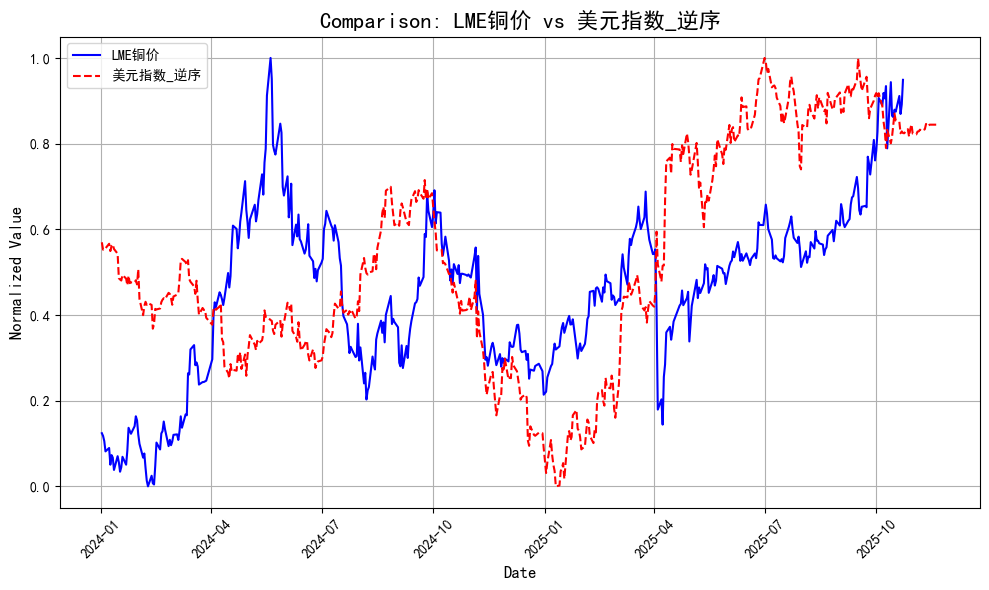

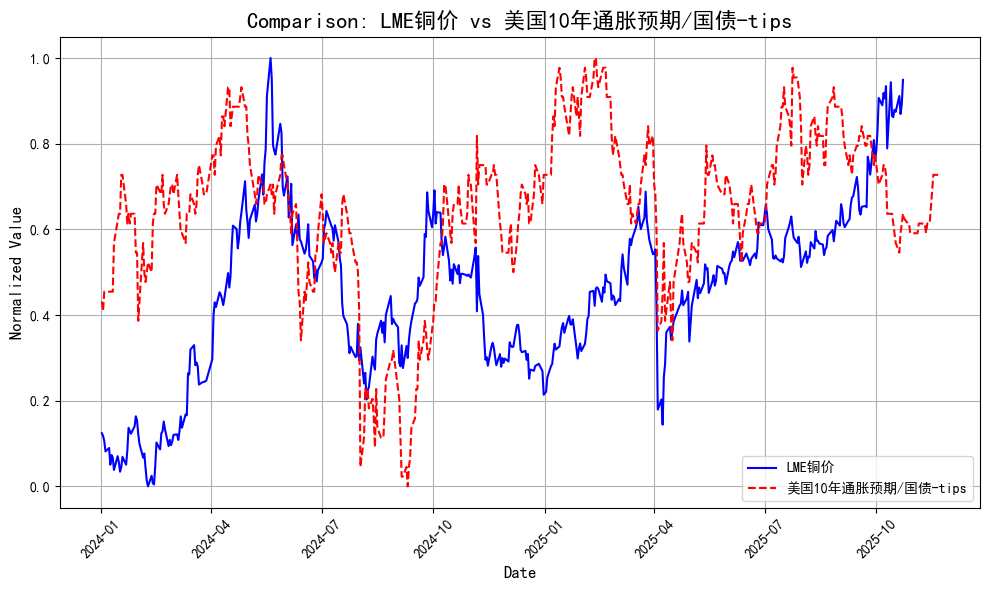

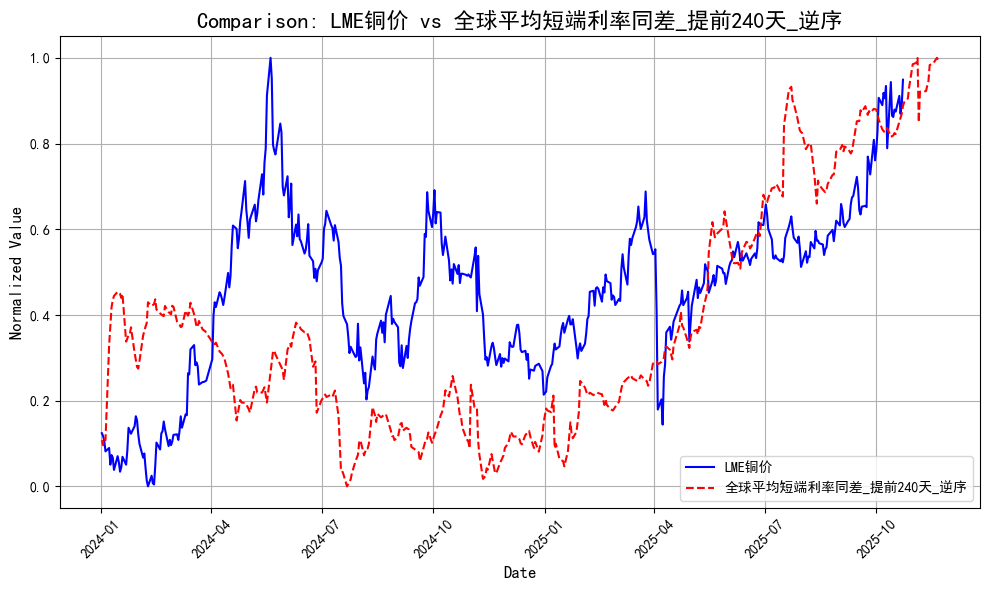

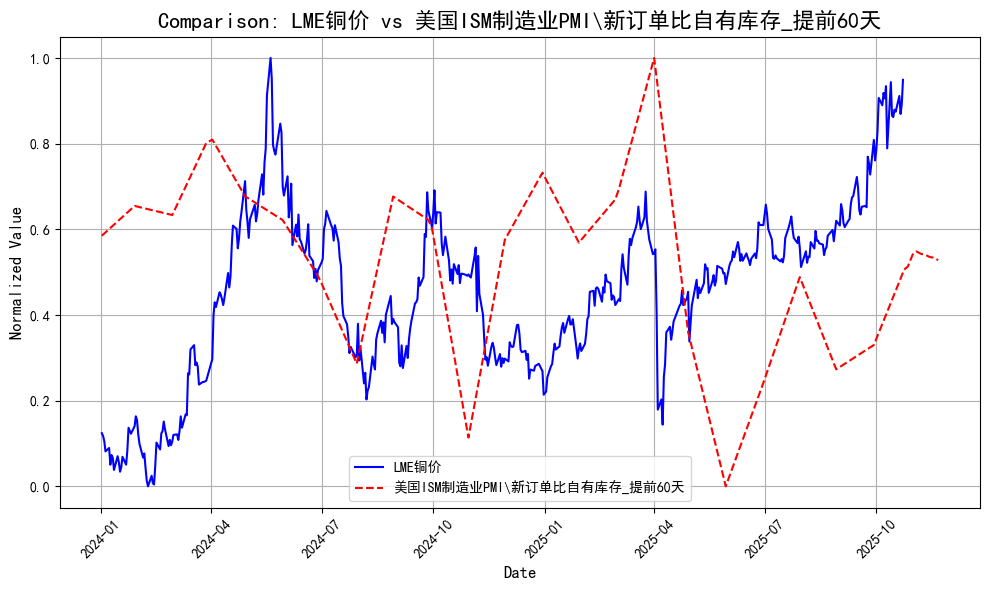

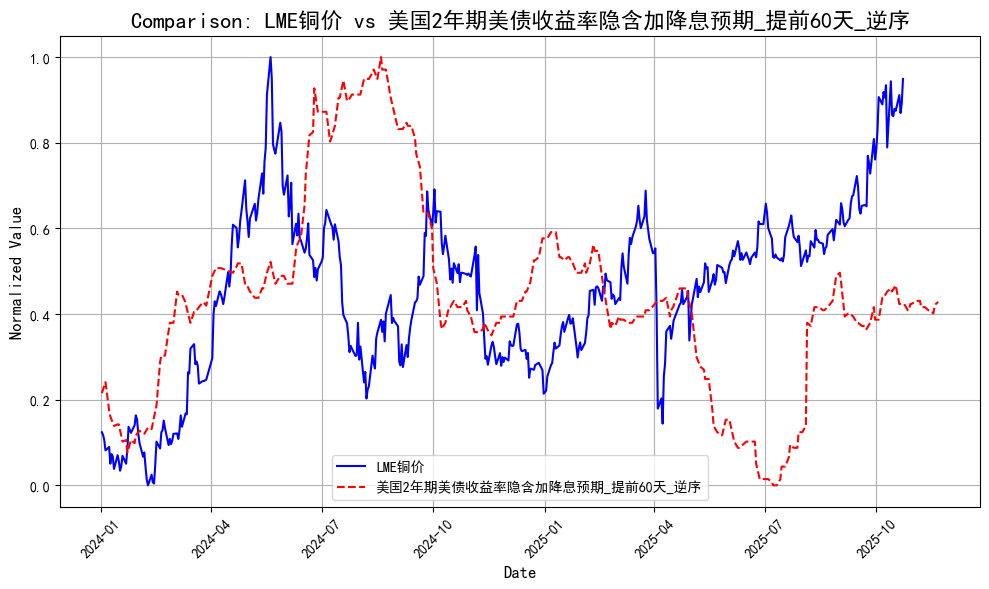

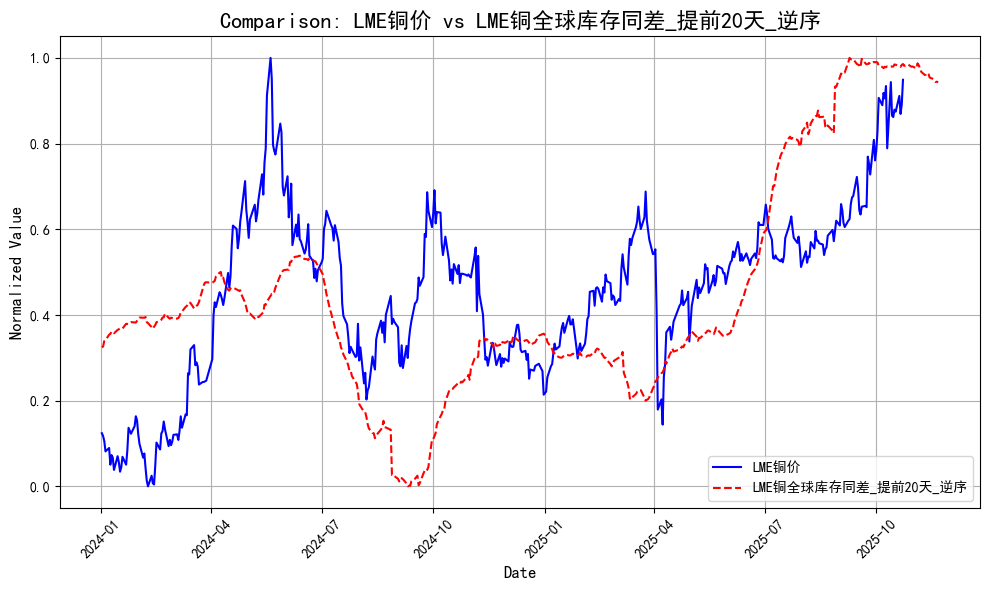

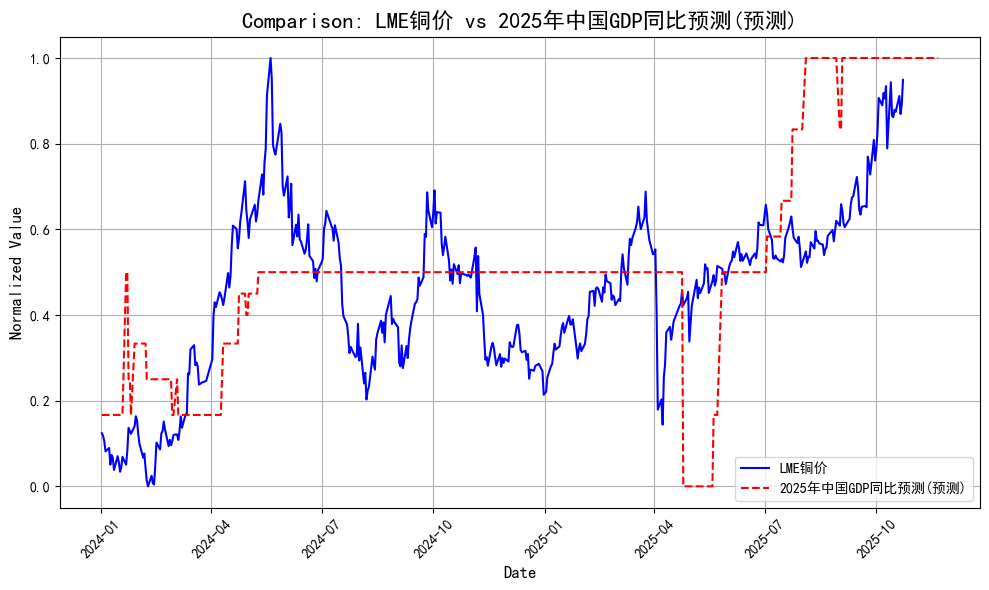

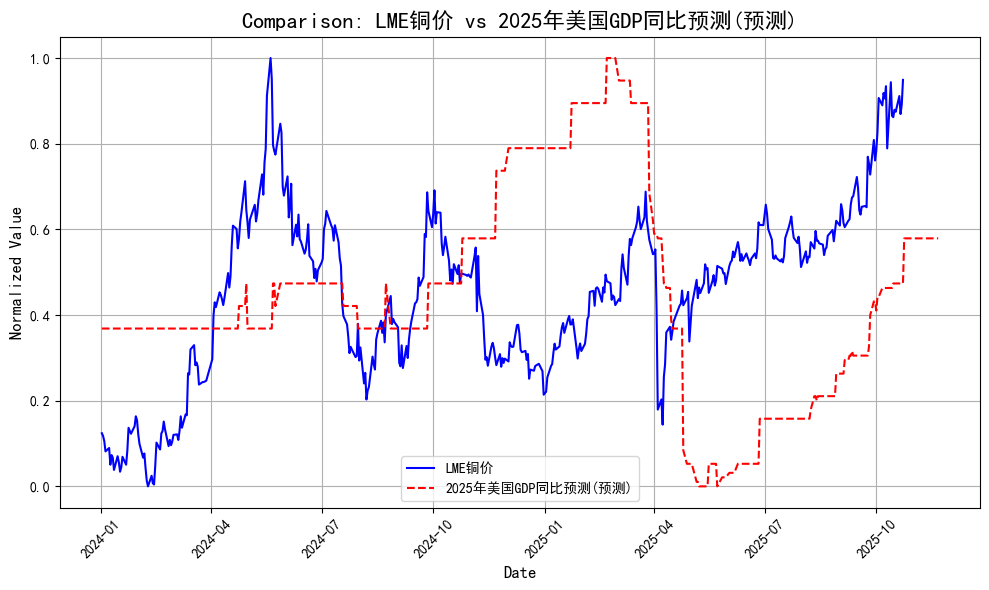

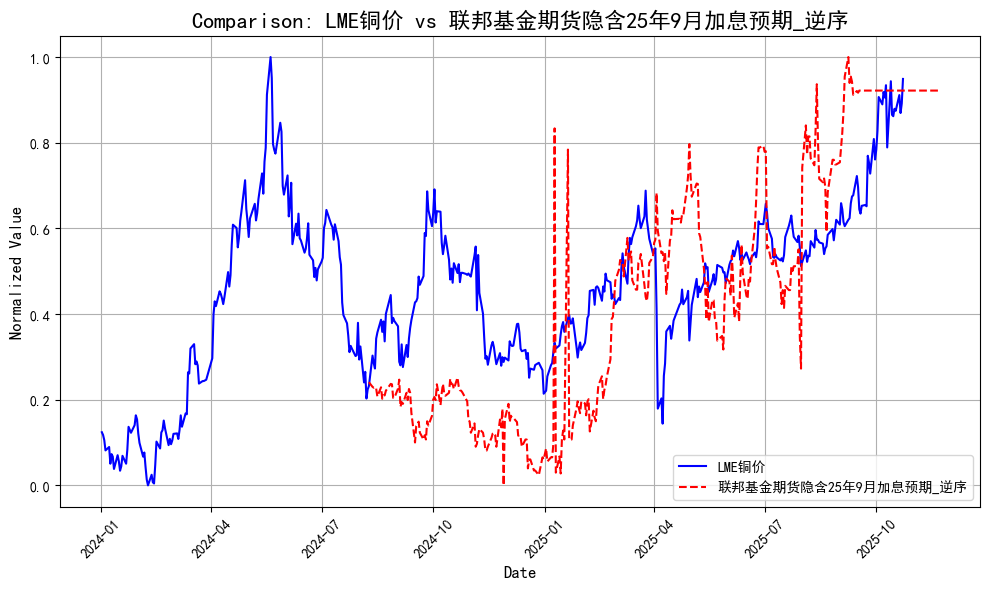

In [12]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='LME铜价', 
    compare_cols=[
        '美元指数_逆序',
        '美国10年通胀预期/国债-tips',
        '全球平均短端利率同差_提前240天_逆序',
        '美国ISM制造业PMI\新订单比自有库存_提前60天',
#        '铜冶炼厂现货粗练费_提前20天_逆序',
#        '铜冶炼厂现货粗练费4周环差_提前20天_逆序',
#        '主要铜材加权开工率(预测)同差',
#       'LME铜库存/鹿特丹_提前40天',
#      '洋山铜溢价_提前35天',
        '美国2年期美债收益率隐含加降息预期_提前60天_逆序',
#        'COMEX-LME铜价差/10DMA20日环差_提前20天',
#        'LME铜全球注册仓单/吨(预测)_逆序',
#        'LME铜全球库存(预测)_逆序',
        'LME铜全球库存同差_提前20天_逆序',
        '2025年中国GDP同比预测(预测)',
        '2025年美国GDP同比预测(预测)',
        '联邦基金期货隐含25年9月加息预期_逆序',
        ]
)

In [13]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 15
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
#        '美元指数_逆序',
#        '美国10年通胀预期/国债-tips',
        '全球平均短端利率同差_提前240天_逆序',
        '美国ISM制造业PMI\新订单比自有库存_提前60天',
        '铜冶炼厂现货粗练费_提前20天_逆序',
#        '铜冶炼厂现货粗练费4周环差_提前20天_逆序',
#        '主要铜材加权开工率(预测)同差',
#       'LME铜库存/鹿特丹_提前40天',
#      '洋山铜溢价_提前35天',
#        '美国2年期美债收益率隐含加降息预期_提前60天_逆序',
#        'COMEX-LME铜价差/10DMA20日环差_提前20天',
#        'LME铜全球注册仓单/吨(预测)_逆序',
#        'LME铜全球库存(预测)_逆序',
        'LME铜全球库存同差_提前20天_逆序',
#        '2025年中国GDP同比预测(预测)',
#        '2025年美国GDP同比预测(预测)',
        '联邦基金期货隐含25年9月加息预期_逆序',
        
]

predict_column = 'LME铜价'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]


'''
################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.0301, 
    'max_depth': 3, 
    'min_child_weight': 2, 
    'subsample': 0.9, 
    'colsample_bytree': 0.9, 
    'gamma': 0.5, 
    'reg_alpha': 0.5, 
    'reg_lambda': 2,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}



num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix
'''

'\n################################# Xgboost 模型 训练 测试 预测 #################################\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\nX_future_scaled = scaler.transform(X_future)\n\ntrain_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)\ntrain_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)\ntest_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)\nfuture_dmatrix = xgb.DMatrix(X_future_scaled)\n\n# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响\nresiduals = np.abs(y_train - y_train.mean())\ndelta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值\nsample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)\ntrain_dmatrix_huber.set_weight(sample_weights_huber)\n\n# 使用z-score思路计算样本权重\nz_scores = np.abs((y_train - y_train.mean()) / y_train.std())\nz_threshold = 2.0  # 设置z-score阈值为2个标准差\nsample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)\ntrain_dmatrix_zscore.set_we

训练集 MSE (TabPFN): 2640.1846, 训练集 R² (TabPFN): 0.9901
测试集 MSE (TabPFN): 132413.3308, 测试集 R² (TabPFN): -10.5731


全部数据 MSE: 3061.9225, 全部数据 R²: 0.99


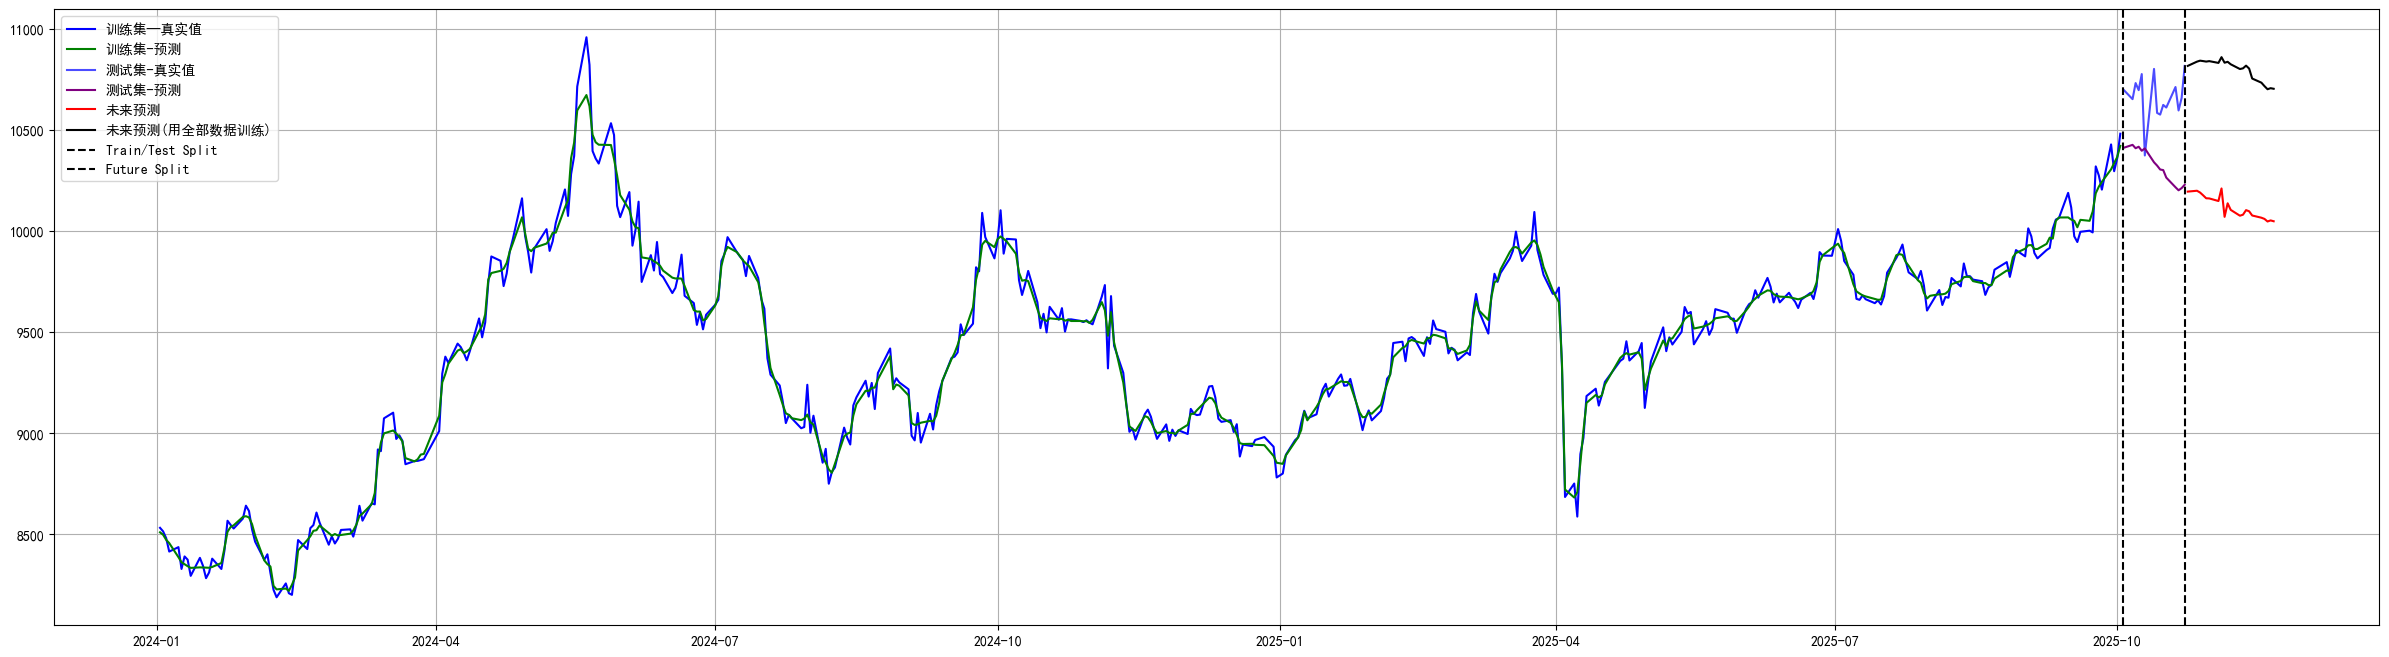

In [14]:

################################# TabPFN 模型 训练 测试 预测 #################################

# 初始化回归器
regressor = TabPFNRegressor(ignore_pretraining_limits=True)
regressor.fit(X_train, y_train)

# 在测试集和未来数据上预测
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE (TabPFN): {round(train_mse, 4)}, 训练集 R² (TabPFN): {round(train_r2, 4)}")
print(f"测试集 MSE (TabPFN): {round(test_mse, 4)}, 测试集 R² (TabPFN): {round(test_r2, 4)}")

# 存储预测结果
y_future_pred = regressor.predict(X_future)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred



################################# TabPFN 模型 训练 测试 预测 所有数据 #################################
# 合并所有数据
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 初始化回归器
regressor_all = TabPFNRegressor(ignore_pretraining_limits=True)
regressor_all.fit(X_all, y_all)

# 预测所有数据和未来数据
y_all_pred = regressor_all.predict(X_all)
y_future_pred_all = regressor_all.predict(X_future)

# 评估模型
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green') 
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('')
plt.legend()
plt.grid(True)  
plt.show()


In [15]:
'''

# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n\n# 可视化训练过程中的评估指标\nplt.figure(figsize=(10, 6))\ntrain_rmse = np.sqrt(evals_result['train']['rmse'])\ntest_rmse = np.sqrt(evals_result['eval']['rmse'])\n\nepochs = len(train_rmse)\nx_axis = range(epochs)\n\nplt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')\nplt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')\n\nplt.xlabel('迭代次数')\nplt.ylabel('RMSE')\nplt.title('XGBoost 模型训练过程中的 RMSE')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [16]:
'''

################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

'''

'\n\n################################# Xgboost 模型 训练 测试 预测 所有数据 #################################\nX_all = pd.concat([X_train, X_test]).reset_index(drop=True)\ny_all = pd.concat([y_train, y_test]).reset_index(drop=True)\n\nX_all_scaled = scaler.transform(X_all)\nX_future_scaled = scaler.transform(X_future)\n\nall_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)\nfuture_dmatrix_all = xgb.DMatrix(X_future_scaled)\n\n# 计算所有数据的样本权重\nresiduals_all = np.abs(y_all - y_all.mean())\nsample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)\n\nall_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重\n\n\n# 训练模型\nmodel_all = xgb.train(\n    params,\n    all_data_dmatrix,\n    num_boost_round,\n    evals=[(all_data_dmatrix, \'train\')],\n    early_stopping_rounds=50,\n    evals_result=evals_result,\n    verbose_eval=100\n)\n\ny_all_pred = model_all.predict(all_data_dmatrix)\ny_future_pred_all = model_all.predict(future_dmatrix_all)\n\nall_mse = mean_squared_error(y_al

In [17]:
'''
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('铜LME铜价')
plt.legend()
plt.grid(True)
plt.show()
'''

"\nplt.figure(figsize=(30, 8))\nfuture_data = plot_predictions(y_test, future_data, col=True, label=True)\nplt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')\nplt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')\nplt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)\nplt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')\nplt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')\nplt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')\n\n# 添加分割线\nplt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')\nplt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')\n\n# 设置标题和图例\nplt.title('铜LME铜价')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [18]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'gain'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()
'''

"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'gain'\nfeature_importance = model_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 gain')\nplt.tight_layout()\nplt.show()\n"

In [19]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'weight'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()
'''

"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'weight'\nfeature_importance = model_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 weight')\nplt.tight_layout()\nplt.show()\n"

In [20]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'cover'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 cover')
plt.tight_layout()
plt.show()
'''

"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'cover'\nfeature_importance = model_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 cover')\nplt.tight_layout()\nplt.show()\n"

In [21]:
'''
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_train_scaled 和 X_train 是 DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# 创建 SHAP Explainer
explainer = shap.Explainer(model_all, X_train_scaled_df)

# 计算 SHAP 值
shap_values = explainer(X_train_scaled_df)

# 提取 SHAP 值数组
shap_values_array = shap_values.values

# 绘制 SHAP Summary Plot
shap.summary_plot(
    shap_values_array,
    X_train,
    feature_names=X_train.columns,
    plot_size=(18, 6)  # 控制图形比例
)
'''

'\nimport shap\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# 确保 X_train_scaled 和 X_train 是 DataFrame\nX_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)\n\n# 创建 SHAP Explainer\nexplainer = shap.Explainer(model_all, X_train_scaled_df)\n\n# 计算 SHAP 值\nshap_values = explainer(X_train_scaled_df)\n\n# 提取 SHAP 值数组\nshap_values_array = shap_values.values\n\n# 绘制 SHAP Summary Plot\nshap.summary_plot(\n    shap_values_array,\n    X_train,\n    feature_names=X_train.columns,\n    plot_size=(18, 6)  # 控制图形比例\n)\n'

In [22]:
'''
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_train_scaled 是 numpy 数组
X_future_scaled_np = np.array(X_future_scaled)

# 创建 LIME 解释器（使用未标准化的数据）
explainer = LimeTabularExplainer(
    X_future_scaled_np,
    feature_names=list(X_train.columns),  
    class_names=['预测值'],
    mode='regression',
    discretize_continuous=False  
)

# 选择一个样本进行解释（最后一个样本）
instance_idx = -1
instance = X_future_scaled_np[instance_idx]

# 还原 instance 到原始数据
instance_original = scaler.inverse_transform([instance])[0]  # 逆变换，变回真实值

# 定义 XGBoost 预测函数
def predict_fn(x):
    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))
    return model_all.predict(dmatrix)

# 生成 LIME 解释
exp = explainer.explain_instance(
    instance, 
    predict_fn, 
    num_features=len(X_train.columns)
)

# 增大图像大小
plt.rcParams.update({'font.size': 20})  
plt.figure(figsize=(30, 20))  
exp.as_pyplot_figure()
plt.title(f"LIME 特征贡献分析（样本 {instance_idx})")
plt.tight_layout()
plt.show()

# 创建贡献度 DataFrame，显示真实值
contributions = pd.DataFrame({
    '特征': X_train.columns,
    'LIME 贡献度': [x[1] for x in exp.as_list()],  # LIME 贡献值
    '原始特征值': instance_original  # 真实的特征值（未标准化）
})

# 打印贡献详情（带原始值）
print("\n未来数据特征贡献详情（真实值）:")
print(contributions[['特征', 'LIME 贡献度', '原始特征值']])

predicted_value = predict_fn([instance])[0]  # 直接使用 XGBoost 的输出
print(f"\n预测值（真实值）: {predicted_value:.4f}")  # 这个已经是真实值
'''

'\nfrom lime.lime_tabular import LimeTabularExplainer\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# 确保 X_train_scaled 是 numpy 数组\nX_future_scaled_np = np.array(X_future_scaled)\n\n# 创建 LIME 解释器（使用未标准化的数据）\nexplainer = LimeTabularExplainer(\n    X_future_scaled_np,\n    feature_names=list(X_train.columns),  \n    class_names=[\'预测值\'],\n    mode=\'regression\',\n    discretize_continuous=False  \n)\n\n# 选择一个样本进行解释（最后一个样本）\ninstance_idx = -1\ninstance = X_future_scaled_np[instance_idx]\n\n# 还原 instance 到原始数据\ninstance_original = scaler.inverse_transform([instance])[0]  # 逆变换，变回真实值\n\n# 定义 XGBoost 预测函数\ndef predict_fn(x):\n    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))\n    return model_all.predict(dmatrix)\n\n# 生成 LIME 解释\nexp = explainer.explain_instance(\n    instance, \n    predict_fn, \n    num_features=len(X_train.columns)\n)\n\n# 增大图像大小\nplt.rcParams.update({\'font.size\': 20})  \nplt.figure(figsize=(30, 20))  \nexp.as_pyplot_figu

In [23]:
'''
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# 创建 LIME 解释器
explainer = LimeTabularExplainer(
    X_train_scaled,  # 标准化后的训练集
    feature_names=list(X_train.columns),  # 确保列名是 Python 列表
    class_names=['预测值'],
    mode='regression'
)

# 选择一个样本进行解释
instance_idx = -1  # 最后一个样本
instance = X_train_scaled[instance_idx]

# 定义预测函数
def predict_fn(x):
    # 将输入转换为 DMatrix，确保列名一致
    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))
    return model_all.predict(dmatrix)  # 返回预测结果

# 使用 LIME 生成解释
exp = explainer.explain_instance(
    instance,           # 输入样本
    predict_fn,         # 自定义预测函数
    num_features=len(X_train.columns)  # 显示所有特征
)

# 绘制特征贡献图（调整宽度以避免布局问题）
plt.figure(figsize=(12, 8))  # 增加图形宽度和高度
exp.as_pyplot_figure()
plt.title(f"LIME 特征贡献分析（样本 {instance_idx})")
plt.tight_layout()
plt.show()

# 打印特征贡献详情
print("\n特征贡献详情:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

# 显示样本预测值和真实值
predicted_value = predict_fn(instance.reshape(1, -1))[0]
real_value = y_train.iloc[instance_idx]
print(f"\n预测值: {predicted_value:.4f}")
print(f"真实值: {real_value:.4f}") 
'''

'\nfrom lime.lime_tabular import LimeTabularExplainer\nimport matplotlib.pyplot as plt\nimport xgboost as xgb\nimport pandas as pd\n\n# 创建 LIME 解释器\nexplainer = LimeTabularExplainer(\n    X_train_scaled,  # 标准化后的训练集\n    feature_names=list(X_train.columns),  # 确保列名是 Python 列表\n    class_names=[\'预测值\'],\n    mode=\'regression\'\n)\n\n# 选择一个样本进行解释\ninstance_idx = -1  # 最后一个样本\ninstance = X_train_scaled[instance_idx]\n\n# 定义预测函数\ndef predict_fn(x):\n    # 将输入转换为 DMatrix，确保列名一致\n    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))\n    return model_all.predict(dmatrix)  # 返回预测结果\n\n# 使用 LIME 生成解释\nexp = explainer.explain_instance(\n    instance,           # 输入样本\n    predict_fn,         # 自定义预测函数\n    num_features=len(X_train.columns)  # 显示所有特征\n)\n\n# 绘制特征贡献图（调整宽度以避免布局问题）\nplt.figure(figsize=(12, 8))  # 增加图形宽度和高度\nexp.as_pyplot_figure()\nplt.title(f"LIME 特征贡献分析（样本 {instance_idx})")\nplt.tight_layout()\nplt.show()\n\n# 打印特征贡献详情\nprint("\n特征贡献详情:")\nfor feature, importance in 

In [24]:
'''
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_future_scaled 是 numpy 数组
X_future_scaled_np = np.array(X_future_scaled)

# 选择特定日期的样本进行解释
target_date = pd.Timestamp('2025-03-31')  # 您想分析的具体日期
date_index = future_data[future_data['Date'] == target_date].index
if len(date_index) == 0:
    print(f"未找到日期 {target_date} 的数据")
    # 显示可用的日期范围
    print(f"可用日期范围: {future_data['Date'].min()} 到 {future_data['Date'].max()}")
else:
    relative_index = date_index[0] - future_data.index[0]  # 计算在X_future_scaled_np中的相对位置
    
    # 确保索引在有效范围内
    if relative_index >= 0 and relative_index < len(X_future_scaled_np):
        instance = X_future_scaled_np[relative_index]
        
        # 还原 instance 到原始数据
        instance_original = scaler.inverse_transform([instance])[0]  # 逆变换，变回真实值
        
        # 定义 XGBoost 预测函数 (使用model_all)
        def predict_fn(x):
            dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))
            return model_all.predict(dmatrix)
        
        # 打印验证信息
        print(f"分析日期: {target_date}")
        print(f"对应future_data中的预测值: {future_data.iloc[relative_index]['预测值_全量']}")
        print(f"LIME预测函数计算的值: {predict_fn([instance])[0]:.6f}")
        
        # 创建 LIME 解释器
        explainer = LimeTabularExplainer(
            X_future_scaled_np,
            feature_names=list(X_train.columns),  
            class_names=['预测值'],
            mode='regression',
            discretize_continuous=False  
        )
        
        # 生成 LIME 解释
        exp = explainer.explain_instance(
            instance, 
            predict_fn, 
            num_features=len(X_train.columns)
        )
        
        # 增大图像大小
        plt.rcParams.update({'font.size': 20})  
        plt.figure(figsize=(30, 20))  
        exp.as_pyplot_figure()
        plt.title(f"LIME 特征贡献分析 (日期: {target_date})")
        plt.tight_layout()
        plt.show()
        
        # 创建贡献度 DataFrame，显示真实值
        contributions = pd.DataFrame({
            '特征': X_train.columns,
            'LIME 贡献度': [x[1] for x in exp.as_list()],  # LIME 贡献值
            '原始特征值': instance_original  # 真实的特征值（未标准化）
        })
        
        # 按贡献度绝对值排序
        contributions['贡献度绝对值'] = contributions['LIME 贡献度'].abs()
        contributions = contributions.sort_values('贡献度绝对值', ascending=False).drop('贡献度绝对值', axis=1)
        
        # 打印贡献详情（带原始值）
        print(f"\n{target_date} 特征贡献详情（真实值）:")
        print(contributions[['特征', 'LIME 贡献度', '原始特征值']])
        
        predicted_value = predict_fn([instance])[0]  # 直接使用 XGBoost 的输出
        print(f"\n预测值（真实值）: {predicted_value:.6f}")  # 这个已经是真实值
    else:
        print(f"计算的相对索引 {relative_index} 超出了有效范围 (0-{len(X_future_scaled_np)-1})")
'''

'\nfrom lime.lime_tabular import LimeTabularExplainer\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# 确保 X_future_scaled 是 numpy 数组\nX_future_scaled_np = np.array(X_future_scaled)\n\n# 选择特定日期的样本进行解释\ntarget_date = pd.Timestamp(\'2025-03-31\')  # 您想分析的具体日期\ndate_index = future_data[future_data[\'Date\'] == target_date].index\nif len(date_index) == 0:\n    print(f"未找到日期 {target_date} 的数据")\n    # 显示可用的日期范围\n    print(f"可用日期范围: {future_data[\'Date\'].min()} 到 {future_data[\'Date\'].max()}")\nelse:\n    relative_index = date_index[0] - future_data.index[0]  # 计算在X_future_scaled_np中的相对位置\n\n    # 确保索引在有效范围内\n    if relative_index >= 0 and relative_index < len(X_future_scaled_np):\n        instance = X_future_scaled_np[relative_index]\n\n        # 还原 instance 到原始数据\n        instance_original = scaler.inverse_transform([instance])[0]  # 逆变换，变回真实值\n\n        # 定义 XGBoost 预测函数 (使用model_all)\n        def predict_fn(x):\n            dmatrix = xgb.DMatrix(x, feature_

---

In [25]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/LME铜价_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
480,2025/11/21,NaN,10703.833984
479,2025/11/20,NaN,10706.736328
478,2025/11/19,NaN,10701.560547
477,2025/11/18,NaN,10716.988281
476,2025/11/17,NaN,10734.043945
...,...,...,...
4,2024/01/08,8437.0,NaN
3,2024/01/05,8415.0,NaN
2,2024/01/04,8481.5,NaN
1,2024/01/03,8515.0,NaN


In [26]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.round(2)
# 保存成excel
merged_df_monthly.to_excel('eta/LME铜价_月度数据.xlsx', index=False, float_format='%.1f')

merged_df_monthly

,Date,真实值,预测值
22,2025/11/30,NaN,10782.179688
21,2025/10/31,10632.68,10463.959961
20,2025/09/30,10059.93,10057.799805
19,2025/08/31,9751.78,9754.929688
18,2025/07/31,9777.07,9774.490234
17,2025/06/30,9704.43,9705.179688
16,2025/05/31,9506.02,9509.009766
15,2025/04/30,9207.33,9206.219727
14,2025/03/31,9759.55,9762.019531
13,2025/02/28,9398.85,9397.190430


In [27]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铜_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "LME铜价"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [28]:
from Lcel import update_excel_data
file_path = "eta/1.铜_数据上传.xlsx"
sheet_name = "详情页"
identifier = "LME铜价"       
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [29]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'LME铜价',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'LME铜价\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'